In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/customer-churn-prediction-2020/sampleSubmission.csv
/kaggle/input/customer-churn-prediction-2020/train.csv
/kaggle/input/customer-churn-prediction-2020/test.csv


In [42]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report
from lightgbm import LGBMClassifier,plot_importance
import catboost as cb 
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Data Gathering

In [3]:
train_df = pd.read_csv('/kaggle/input/customer-churn-prediction-2020/train.csv')
test_df = pd.read_csv('/kaggle/input/customer-churn-prediction-2020/test.csv')
print(f"Shape of tarin_df = {train_df.shape}")
print(f"Shape of test_df = {test_df.shape}")

Shape of tarin_df = (4250, 20)
Shape of test_df = (750, 20)


# Data overview

In [4]:
train_df.head()

,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn
0,OH,107,area_code_415,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,no
1,NJ,137,area_code_415,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,no
2,OH,84,area_code_408,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,no
3,OK,75,area_code_415,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,no
4,MA,121,area_code_510,no,yes,24,218.2,88,37.09,348.5,108,29.62,212.6,118,9.57,7.5,7,2.03,3,no


In [5]:
test_df.head()

,id,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls
0,1,KS,128,area_code_415,no,yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1
1,2,AL,118,area_code_510,yes,no,0,223.4,98,37.98,220.6,101,18.75,203.9,118,9.18,6.3,6,1.70,0
2,3,IA,62,area_code_415,no,no,0,120.7,70,20.52,307.2,76,26.11,203.0,99,9.14,13.1,6,3.54,4
3,4,VT,93,area_code_510,no,no,0,190.7,114,32.42,218.2,111,18.55,129.6,121,5.83,8.1,3,2.19,3
4,5,NE,174,area_code_415,no,no,0,124.3,76,21.13,277.1,112,23.55,250.7,115,11.28,15.5,5,4.19,3


In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4250 entries, 0 to 4249
Data columns (total 20 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   state                          4250 non-null   object 
 1   account_length                 4250 non-null   int64  
 2   area_code                      4250 non-null   object 
 3   international_plan             4250 non-null   object 
 4   voice_mail_plan                4250 non-null   object 
 5   number_vmail_messages          4250 non-null   int64  
 6   total_day_minutes              4250 non-null   float64
 7   total_day_calls                4250 non-null   int64  
 8   total_day_charge               4250 non-null   float64
 9   total_eve_minutes              4250 non-null   float64
 10  total_eve_calls                4250 non-null   int64  
 11  total_eve_charge               4250 non-null   float64
 12  total_night_minutes            4250 non-null   f

In [7]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750 entries, 0 to 749
Data columns (total 20 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   id                             750 non-null    int64  
 1   state                          750 non-null    object 
 2   account_length                 750 non-null    int64  
 3   area_code                      750 non-null    object 
 4   international_plan             750 non-null    object 
 5   voice_mail_plan                750 non-null    object 
 6   number_vmail_messages          750 non-null    int64  
 7   total_day_minutes              750 non-null    float64
 8   total_day_calls                750 non-null    int64  
 9   total_day_charge               750 non-null    float64
 10  total_eve_minutes              750 non-null    float64
 11  total_eve_calls                750 non-null    int64  
 12  total_eve_charge               750 non-null    flo

# Data Cleaning

## 1. Handling Missing Values

Handling missing values is another important step in data cleaning. Missing values can be represented as `NaN` (Not a Number) or empty strings. I use the `isna()` function to identify missing values and the `dropna()` function to remove rows with missing values. 

In [8]:
train_df.isna().sum()

state                            0
account_length                   0
area_code                        0
international_plan               0
voice_mail_plan                  0
number_vmail_messages            0
total_day_minutes                0
total_day_calls                  0
total_day_charge                 0
total_eve_minutes                0
total_eve_calls                  0
total_eve_charge                 0
total_night_minutes              0
total_night_calls                0
total_night_charge               0
total_intl_minutes               0
total_intl_calls                 0
total_intl_charge                0
number_customer_service_calls    0
churn                            0
dtype: int64

In [9]:
test_df.isna().sum()

id                               0
state                            0
account_length                   0
area_code                        0
international_plan               0
voice_mail_plan                  0
number_vmail_messages            0
total_day_minutes                0
total_day_calls                  0
total_day_charge                 0
total_eve_minutes                0
total_eve_calls                  0
total_eve_charge                 0
total_night_minutes              0
total_night_calls                0
total_night_charge               0
total_intl_minutes               0
total_intl_calls                 0
total_intl_charge                0
number_customer_service_calls    0
dtype: int64

## 2. Handling Duplicate Values

Handling duplicate values involves identifying and removing duplicate rows from the DataFrame. I use the `duplicated()` function to identify duplicate rows and the `drop_duplicates()` function to remove them.

In [10]:
 print(f"Duplicated values: {train_df.duplicated().sum()}", "duplicated rows") 

Duplicated values: 0 duplicated rows


In [11]:
 print(f"Duplicated values: {test_df.duplicated().sum()}", "duplicated rows") 

Duplicated values: 0 duplicated rows


# Descriptive Statistics

In [12]:
# Identifying numeric and categorical columns from train_df
num_cols, cat_cols = train_df.select_dtypes(exclude=['object']), train_df.select_dtypes(include=['object'])

In [13]:
num_cols.describe()

,account_length,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls
count,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000
mean,100.236235,7.631765,180.259600,99.907294,30.644682,200.173906,100.176471,17.015012,200.527882,99.839529,9.023892,10.256071,4.426353,2.769654,1.559059
std,39.698401,13.439882,54.012373,19.850817,9.182096,50.249518,19.908591,4.271212,50.353548,20.093220,2.265922,2.760102,2.463069,0.745204,1.311434
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,73.000000,0.000000,143.325000,87.000000,24.365000,165.925000,87.000000,14.102500,167.225000,86.000000,7.522500,8.500000,3.000000,2.300000,1.000000
50%,100.000000,0.000000,180.450000,100.000000,30.680000,200.700000,100.000000,17.060000,200.450000,100.000000,9.020000,10.300000,4.000000,2.780000,1.000000
75%,127.000000,16.000000,216.200000,113.000000,36.750000,233.775000,114.000000,19.867500,234.700000,113.000000,10.560000,12.000000,6.000000,3.240000,2.000000
max,243.000000,52.000000,351.500000,165.000000,59.760000,359.300000,170.000000,30.540000,395.000000,175.000000,17.770000,20.000000,20.000000,5.400000,9.000000


In [14]:
cat_cols.describe()

,state,area_code,international_plan,voice_mail_plan,churn
count,4250,4250,4250,4250,4250
unique,51,3,2,2,2
top,WV,area_code_415,no,no,no
freq,139,2108,3854,3138,3652


# Data Visualisation

## Univariate analysis
In univariate analysis, where only one variable is considered at a time. These visualizations help to understand the central tendency, spread, and shape of the distribution of a single variable.

### Distribution of Numerical Features

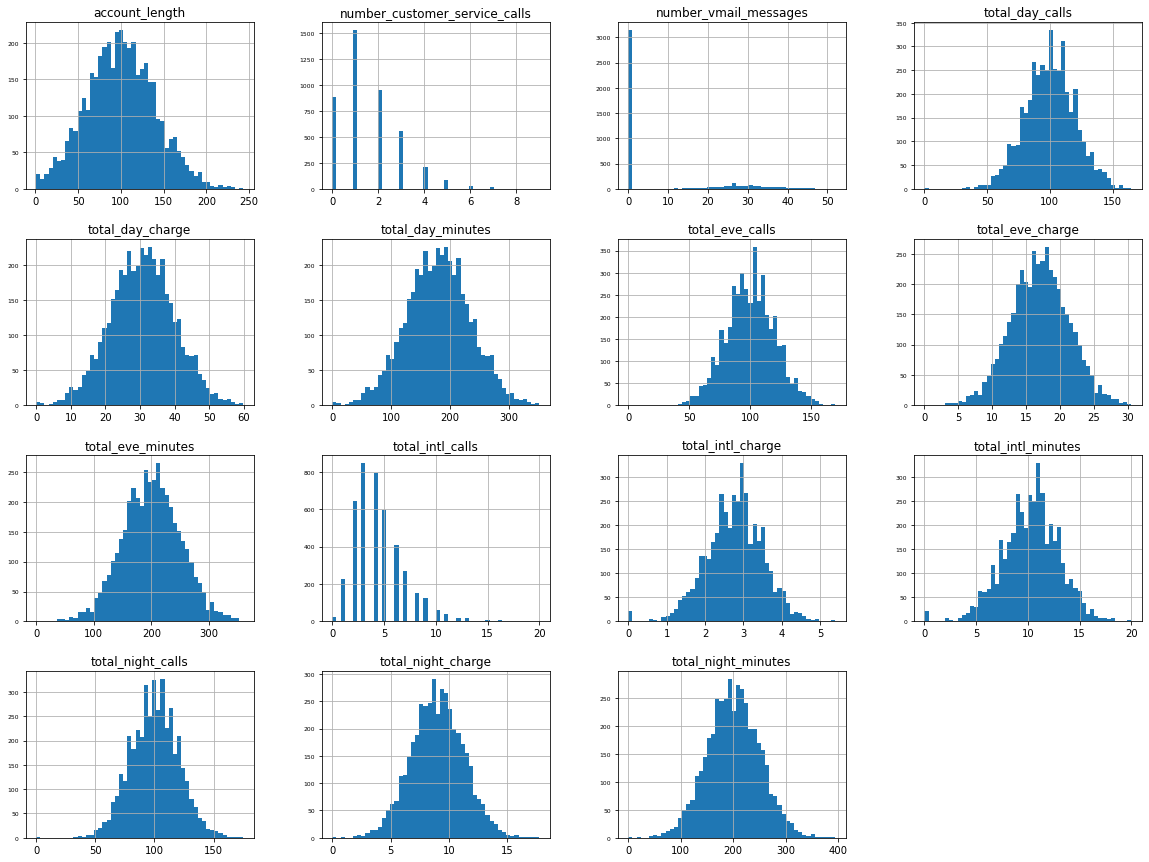

In [15]:
num_cols.hist(figsize=(20, 15), bins=50, ylabelsize=6)
plt.title("Histogram of Features that has a num type")
plt.show()

### Distributions of categorical features

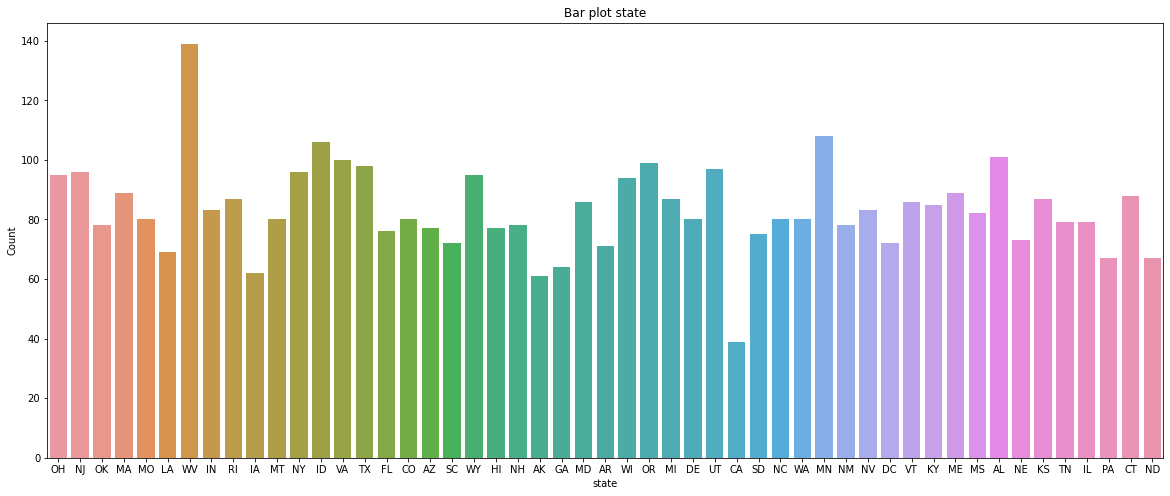

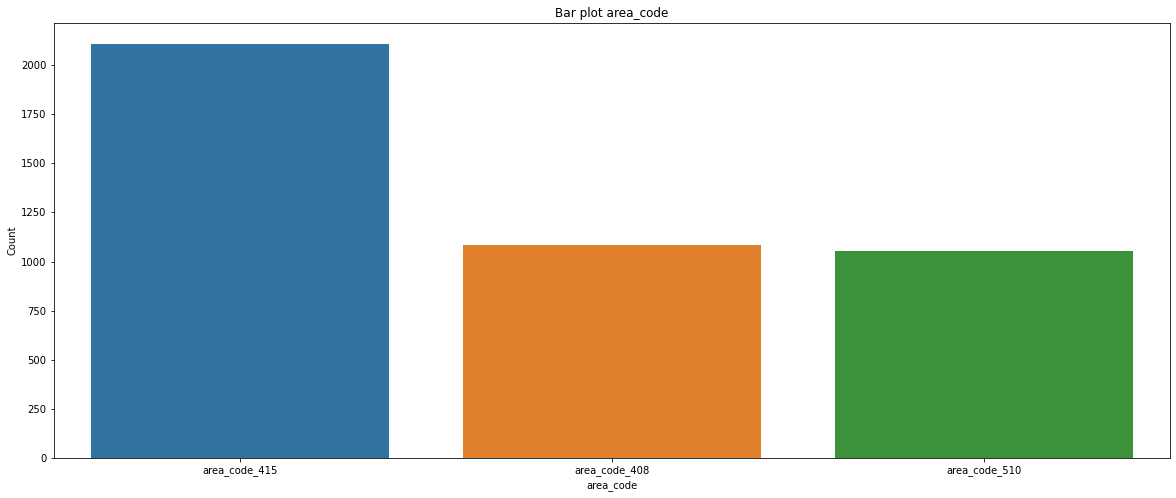

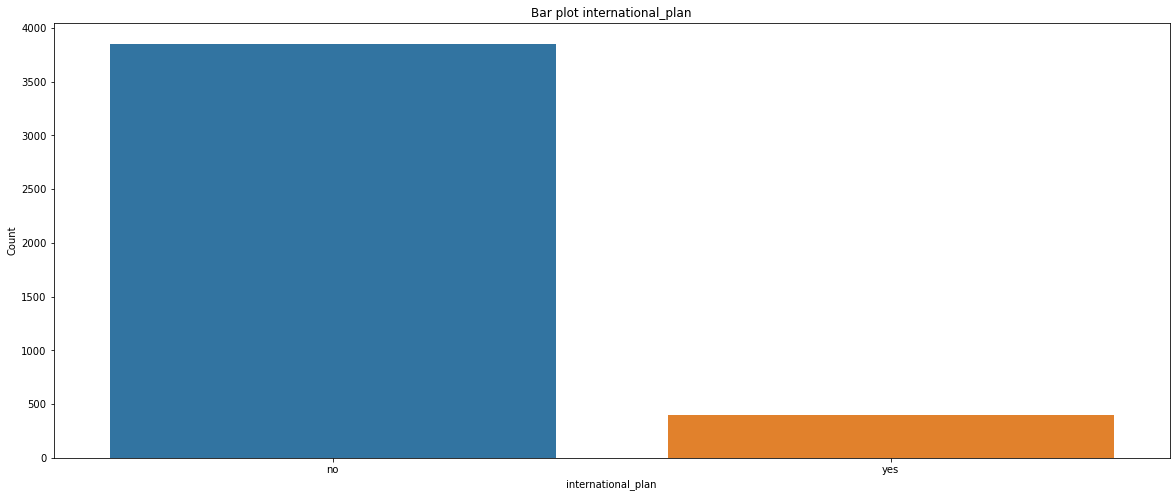

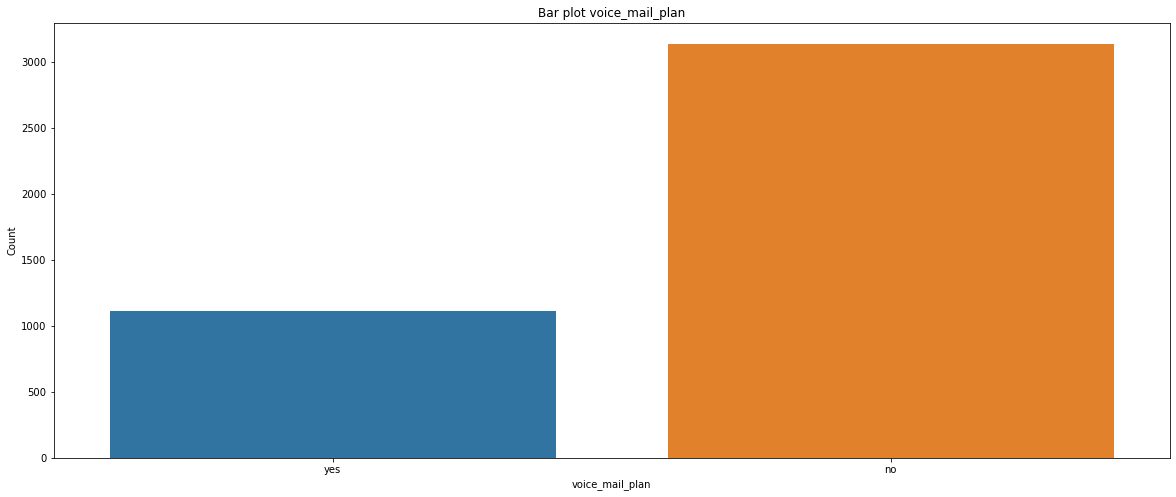

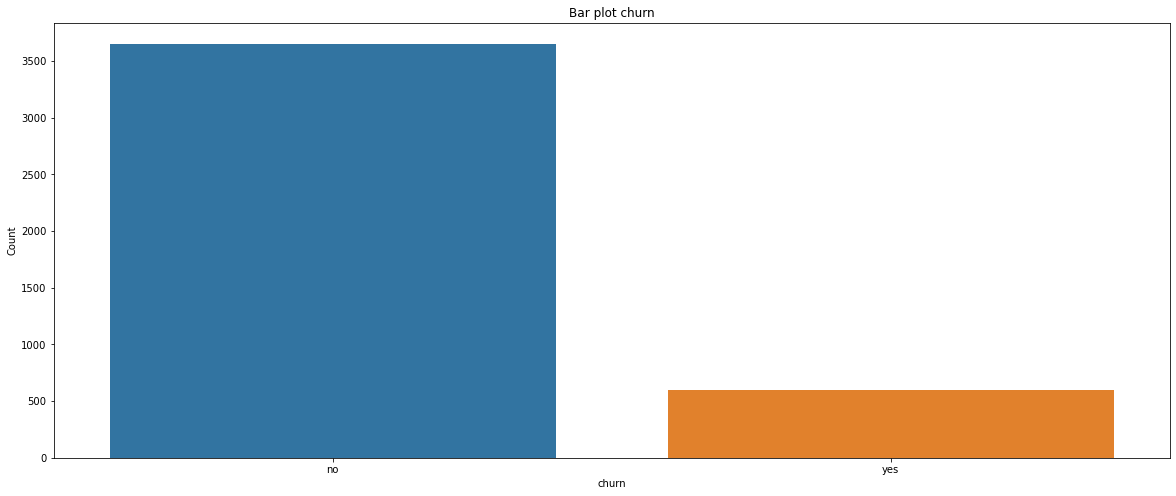

In [16]:
def plot_categorical_features(data):
    ''' Plot categorical features'''
    
    for col in data.columns:
        plt.figure(figsize=(20, 8))
        sns.countplot(x=col, data=data)
        plt.title(f"Bar plot {col}")
        plt.ylabel("Count")
        plt.xlabel(col)
        plt.show()

plot_categorical_features(cat_cols)

### Bivariate analysis and Multivariate analysis
Multivariate analysis involves the study of three or more variables simultaneously. Visualizations for multivariate data can be more complex.

Bivariate analysis examines the relationship between two variables.

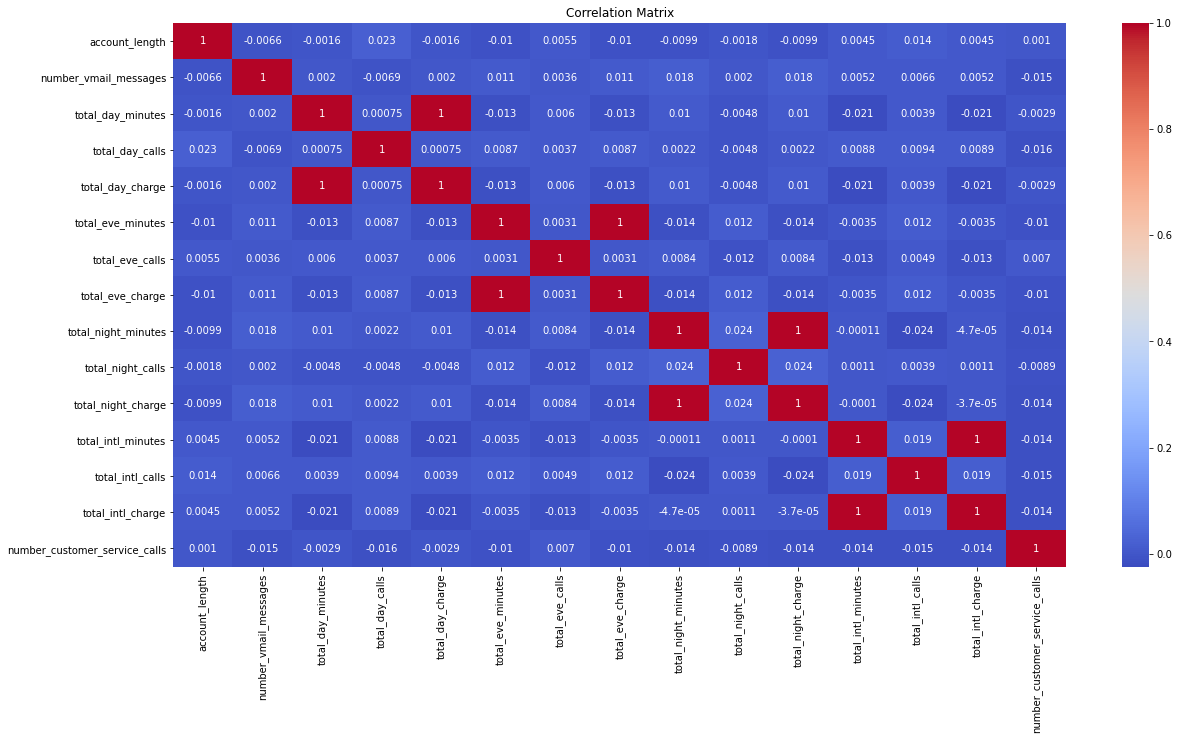

In [18]:
coff = num_cols.corr()
plt.figure(figsize = (20, 10))
sns.heatmap(coff, annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

# Data Encoding and Scaling

In [23]:
for col in cat_cols.columns:
    train_df[col] = train_df[col].astype('category')
train_df.dtypes

state                            category
account_length                      int64
area_code                        category
international_plan               category
voice_mail_plan                  category
number_vmail_messages               int64
total_day_minutes                 float64
total_day_calls                     int64
total_day_charge                  float64
total_eve_minutes                 float64
total_eve_calls                     int64
total_eve_charge                  float64
total_night_minutes               float64
total_night_calls                   int64
total_night_charge                float64
total_intl_minutes                float64
total_intl_calls                    int64
total_intl_charge                 float64
number_customer_service_calls       int64
churn                            category
dtype: object

In [25]:
binary_cat_cols = ["international_plan", "voice_mail_plan", "churn"]
encoder = LabelEncoder()
for col in binary_cat_cols:
    train_df[col] = encoder.fit_transform(train_df[col])
train_df.sample(3)

,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn
1497,AL,68,area_code_510,0,0,0,157.3,83,26.74,220.9,85,18.78,218.9,129,9.85,12.0,7,3.24,1,0
942,MI,91,area_code_415,0,0,0,154.4,165,26.25,168.3,121,14.31,239.9,81,10.80,11.7,4,3.16,5,1
2280,KS,79,area_code_415,0,0,0,177.9,83,30.24,167.3,84,14.22,223.7,142,10.07,15.2,8,4.10,0,0


In [26]:
# checking variance of numeric columns
num_cols.var()

account_length                   1575.963008
number_vmail_messages             180.630433
total_day_minutes                2917.336473
total_day_calls                   394.054948
total_day_charge                   84.310888
total_eve_minutes                2525.014078
total_eve_calls                   396.352000
total_eve_charge                   18.243252
total_night_minutes              2535.479804
total_night_calls                 403.737482
total_night_charge                  5.134402
total_intl_minutes                  7.618162
total_intl_calls                    6.066709
total_intl_charge                   0.555329
number_customer_service_calls       1.719858
dtype: float64

In [31]:
scaler = StandardScaler()
for col in num_cols.columns:
    train_df[col] = scaler.fit_transform(train_df[col].values.reshape(-1, 1))
train_df[num_cols.columns].var()

account_length                   1.000235
number_vmail_messages            1.000235
total_day_minutes                1.000235
total_day_calls                  1.000235
total_day_charge                 1.000235
total_eve_minutes                1.000235
total_eve_calls                  1.000235
total_eve_charge                 1.000235
total_night_minutes              1.000235
total_night_calls                1.000235
total_night_charge               1.000235
total_intl_minutes               1.000235
total_intl_calls                 1.000235
total_intl_charge                1.000235
number_customer_service_calls    1.000235
dtype: float64

# Model Training

In [32]:
X = train_df.drop('churn',axis=1)
y  = train_df['churn']
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.2, random_state=45, stratify=y)

### CATBOOST

In [43]:
cat_cols = train_df.select_dtypes(include=['category'])
train_pool = cb.Pool(X_train,y_train, cat_features=cat_cols)
test_pool = cb.Pool(X_test,y_test, cat_features=cat_cols)

In [45]:
cat_model = cb.CatBoostClassifier(loss_function='Logloss', eval_metric='Accuracy')


In [46]:
grid = {'learning_rate': [0.03, 0.1], 'depth': [4, 6, 10], 'l2_leaf_reg': [1, 3, 5,],'iterations': [50, 100, 150]}
cat_model.grid_search(grid,train_pool)
cat_model.get_params()


bestTest = 0.925
bestIteration = 49

0:	loss: 0.9250000	best: 0.9250000 (0)	total: 246ms	remaining: 13s

bestTest = 0.9455882353
bestIteration = 49

1:	loss: 0.9455882	best: 0.9455882 (1)	total: 399ms	remaining: 10.4s

bestTest = 0.925
bestIteration = 45

2:	loss: 0.9250000	best: 0.9455882 (1)	total: 554ms	remaining: 9.41s

bestTest = 0.95
bestIteration = 43

3:	loss: 0.9500000	best: 0.9500000 (3)	total: 708ms	remaining: 8.85s

bestTest = 0.9176470588
bestIteration = 47

4:	loss: 0.9176471	best: 0.9500000 (3)	total: 867ms	remaining: 8.49s

bestTest = 0.9514705882
bestIteration = 47

5:	loss: 0.9514706	best: 0.9514706 (5)	total: 1.02s	remaining: 8.19s

bestTest = 0.9441176471
bestIteration = 99

6:	loss: 0.9441176	best: 0.9514706 (5)	total: 1.33s	remaining: 8.93s

bestTest = 0.9529411765
bestIteration = 72

7:	loss: 0.9529412	best: 0.9529412 (7)	total: 1.63s	remaining: 9.38s

bestTest = 0.9411764706
bestIteration = 89

8:	loss: 0.9411765	best: 0.9529412 (7)	total: 1.94s	remaining: 9.72

{'loss_function': 'Logloss',
 'eval_metric': 'Accuracy',
 'depth': 10,
 'l2_leaf_reg': 1,
 'iterations': 100,
 'learning_rate': 0.1}

In [48]:
pred = cat_model.predict(X_test)

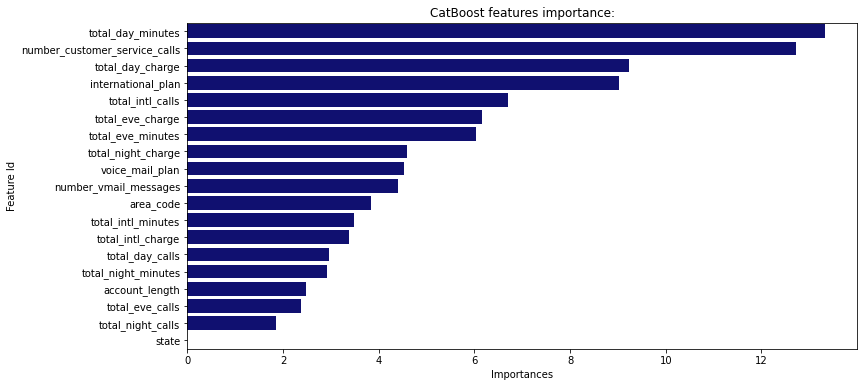

In [60]:
feature_importance_df = cat_model.get_feature_importance(prettified=True)
plt.figure(figsize=(12, 6));
sns.barplot(y="Feature Id", x="Importances", data=feature_importance_df, color='navy');
plt.title('CatBoost features importance:');

#### Model Evaluation

In [49]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97       730
           1       0.93      0.71      0.81       120

    accuracy                           0.95       850
   macro avg       0.94      0.85      0.89       850
weighted avg       0.95      0.95      0.95       850



### LightGBM

In [33]:
light = LGBMClassifier(n_estimators=200,learning_rate=0.11,
                      min_child_samples=30,num_leaves=60)
light.fit(X_train,y_train)

LGBMClassifier(learning_rate=0.11, min_child_samples=30, n_estimators=200,
               num_leaves=60)

In [51]:
light_pred = light.predict(X_test)

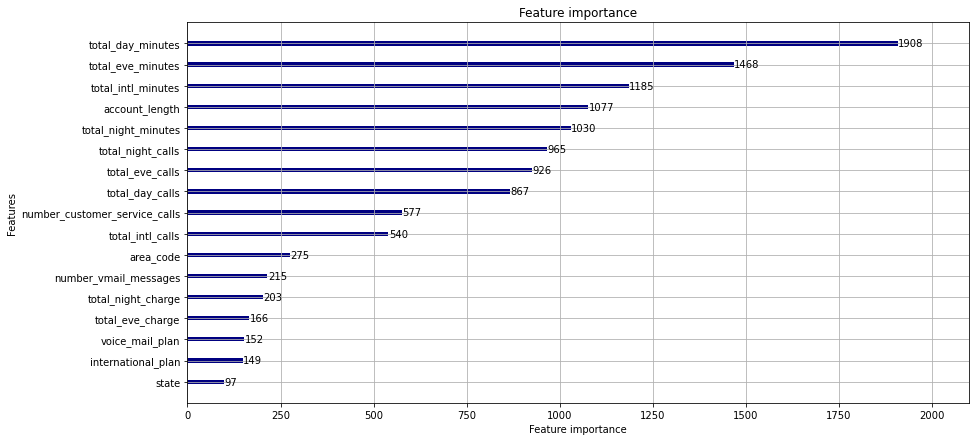

In [35]:
plt.rcParams["figure.figsize"] = (14, 7)
plot_importance(light,color='navy',)

#### Model Evaluation

In [52]:
print(classification_report(y_test, light_pred))

              precision    recall  f1-score   support

           0       0.96      0.99      0.98       730
           1       0.93      0.75      0.83       120

    accuracy                           0.96       850
   macro avg       0.94      0.87      0.90       850
weighted avg       0.96      0.96      0.95       850

